# COMP 4630 - ML Final Project

## Retrieving and Analyzing the Data
Installation of Kagglehub and downloading dataset. Use of pandas and numpy to anaylze the data and sort out information.

In [1]:
# pip install --upgrade kagglehub

In [2]:
import kagglehub
path = kagglehub.dataset_download("hosseinah1/poker-game-dataset")
print("Path to dataset files:", path)

100%|██████████| 6.57M/6.57M [00:00<00:00, 54.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hosseinah1/poker-game-dataset/versions/1


In [3]:
import pandas as pd
import numpy as np

trainDS = pd.read_csv(path+"/poker-hand-training.csv")
trainDS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25010 entries, 0 to 25009
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Suit of Card 1  25010 non-null  int64
 1   Rank of Card 1  25010 non-null  int64
 2   Suit of Card 2  25010 non-null  int64
 3   Rank of Card 2  25010 non-null  int64
 4   Suit of Card 3  25010 non-null  int64
 5   Rank of Card 3  25010 non-null  int64
 6   Suit of Card 4  25010 non-null  int64
 7   Rank of Card 4  25010 non-null  int64
 8   Suit of Card 5  25010 non-null  int64
 9   Rank of Card 5  25010 non-null  int64
 10  Poker Hand      25010 non-null  int64
dtypes: int64(11)
memory usage: 2.1 MB


In [4]:
trainDS.head()

,Suit of Card 1,Rank of Card 1,Suit of Card 2,Rank of Card 2,Suit of Card 3,Rank of Card 3,Suit of Card 4,Rank of Card 4,Suit of Card 5,Rank of Card 5,Poker Hand
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


### Metadata
Dataframe has 11 columns, with the last column refering to the poker hand the five cards make. The remaining 10 columns refer to the five cards, with the column referring to each card in pairs: suit column and rank column per card.

In an attempt to simplify the data and make it visually easier to understand, I will be incorporating unicode for both suits and possibly cards (depending on structure). However, *individual columns of the dataset* are relatively meaningless without adjacencies with all other properties.


,count
Poker Hand,
0,12493
1,10599
2,1206
3,513
4,93
5,54
6,36
7,6
8,5


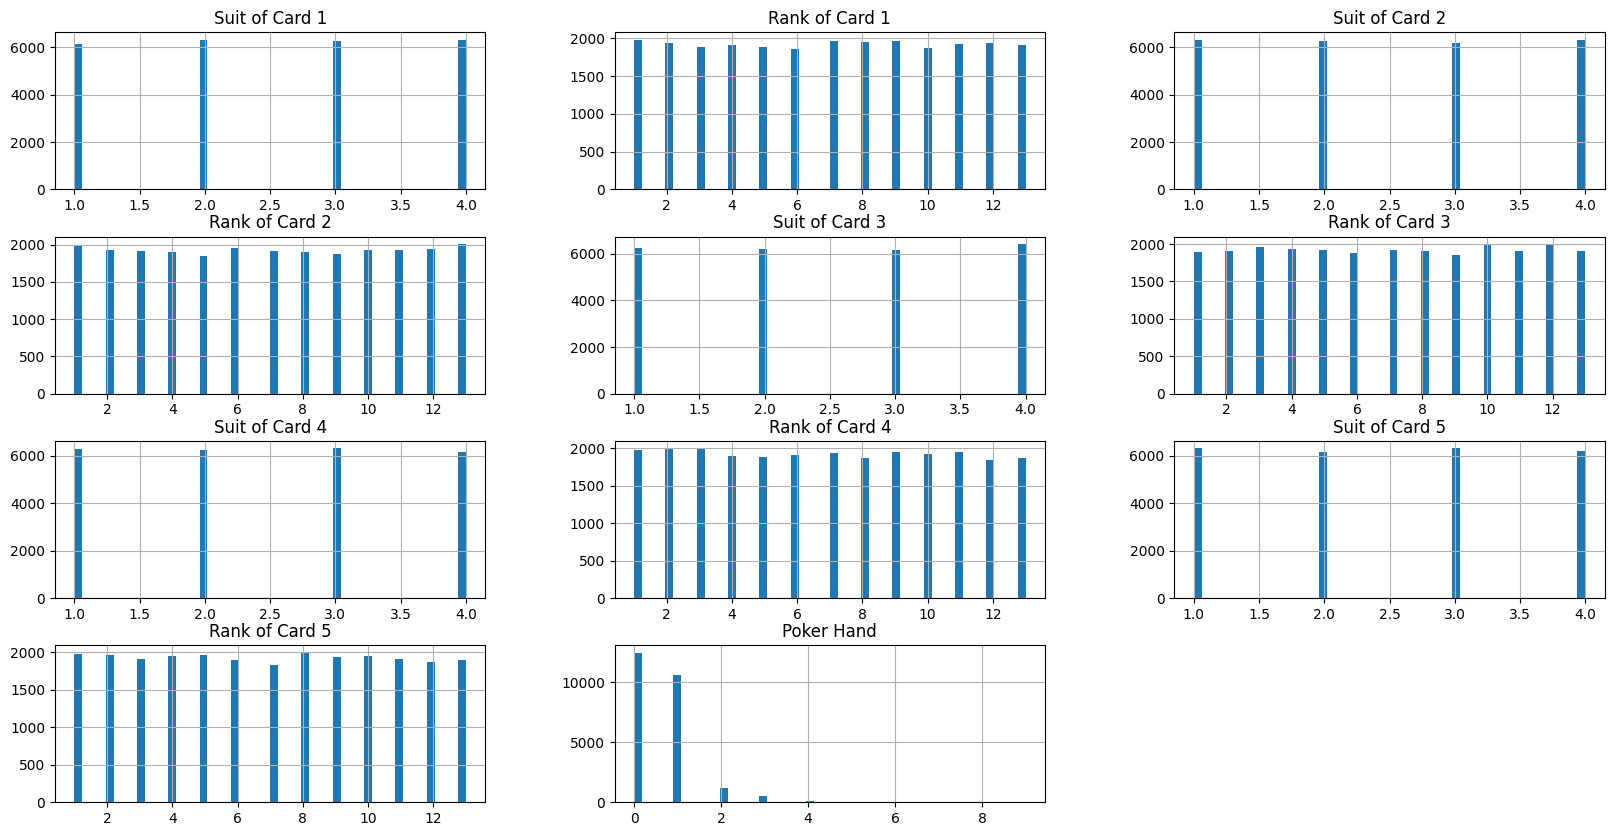

In [5]:
trainDS.hist(bins=50, figsize=(20, 10))
trainDS["Poker Hand"].value_counts()
# Data Sanity Check

## Data Pre-Processing
Setup of data to handle correlations and labels. First block checks each row to see if there's an ample amount of data available to allow a model to classify.


### Correlation

NOTE: Correlation matrix relatively useless without pairing of rank and suit of card. Albeit, the correlations would likely be the similar without specifying poker hands.

In [6]:
corrMatrix = trainDS.corr(numeric_only=True)
corrMatrix["Poker Hand"].sort_values(ascending=False)

,Poker Hand
Poker Hand,1.000000
Rank of Card 4,0.010163
Suit of Card 1,0.008244
Suit of Card 3,0.003951
Rank of Card 1,0.002312
Suit of Card 2,-0.001135
Suit of Card 4,-0.001552
Rank of Card 5,-0.002414
Rank of Card 2,-0.005191
Suit of Card 5,-0.005616


### Card Property Tuple ( {Suit}{Rank} )

Simple card printing. From initial attempt to display cards as well as pair them for analysis purposes. This is also where rank of 1 for Aces was seen as problematic. First code block spits out three random samples to display and show attribute setup within dataset.

NOTE: Was unutilized, ended up using a basic classification model

In [7]:
trainDS.sample(3)

,Suit of Card 1,Rank of Card 1,Suit of Card 2,Rank of Card 2,Suit of Card 3,Rank of Card 3,Suit of Card 4,Rank of Card 4,Suit of Card 5,Rank of Card 5,Poker Hand
9699,3,3,4,5,3,7,1,7,3,5,2
12412,4,5,2,13,2,12,2,4,3,7,0
302,3,2,3,11,1,1,4,7,4,2,1


In [8]:
# print("\u2660"+"\u2661"+"\u2662"+"\u2663")
suits = ["\u2660", "\u2661", "\u2662", "\u2663"]  # ♠♡♢♣
face = ['J','Q','K'] # Rank 11, 12, 13

sampleHand = trainDS.sample(1)
columns = list(sampleHand.columns)

for i, col in enumerate(columns):
    sampleHand[col] = sampleHand[col].astype("object")
    if "Suit" in col and (i + 1) < len(columns):
        rankCol = columns[i + 1]

        for index in sampleHand.index:
            suit_val = sampleHand.at[index, col]
            rank_val = sampleHand.at[index, rankCol]
            if rank_val > 10:
              rank_val = face[rank_val-11]
            if rank_val == 1:
              rank_val = 'A'

            suit_symbol = suits[suit_val - 1]
            card = f"{suit_symbol}{rank_val}"

            sampleHand.at[index, col] = card
            print(card)

    if "Poker Hand" in col:
      print(sampleHand[col])


♣7
♡A
♠2
♡8
♡K
15219    0
Name: Poker Hand, dtype: object


## Post-Data Analysis



In [9]:
feature_columns = [col for col in trainDS.columns if col != 'Poker Hand']

X = trainDS[feature_columns]
y = trainDS['Poker Hand']


In [25]:
import tensorflow as tf
from tensorflow.keras import layers

num_classes = y.nunique()

model = tf.keras.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [26]:
from sklearn.model_selection import train_test_split

testDS = pd.read_csv(path+"/poker-hand-testing.csv")

X_train = trainDS.drop(columns=["Poker Hand"])
y_train = trainDS["Poker Hand"]

X_test = testDS.drop(columns=["Poker Hand"])
y_test = testDS["Poker Hand"]

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test Loss    : {loss:.3f}")


Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4931 - loss: 1.0654 - val_accuracy: 0.5210 - val_loss: 0.9748
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5334 - loss: 0.9686 - val_accuracy: 0.5266 - val_loss: 0.9562
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5349 - loss: 0.9661 - val_accuracy: 0.5342 - val_loss: 0.9508
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5527 - loss: 0.9479 - val_accuracy: 0.5326 - val_loss: 0.9486
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5565 - loss: 0.9438 - val_accuracy: 0.5366 - val_loss: 0.9403
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5607 - loss: 0.9368 - val_accuracy: 0.5386 - val_loss: 0.9302
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5646 - loss: 0.9341 - val_accuracy: 0.5350 - val_loss: 0.9341
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5704 - loss: 0.9197 - val_accu